# 1. 데이터 읽기

기상자료개방포털의 **동네예보 > 초단기실황** 데이터를 크롤러를 만들어 2019.08~2021.08 데이터를 수집하였다. 지역의 범위는 이어도를 제외한 전체지역이다.

In [34]:
import os
import glob 
import pandas as pd
import numpy as np



1. 압축풀고 강수형태, 강수, 기온 폴더 만들기
2. glob(*.csv)으로 폴더 내에 있는 파일 이름 몽땅 읽기
3. 읽어서 file_list에 저장하고
4. file_list에서 강수형태, 강수, 기온으로 분류해서 옮기기
5. 그럼 각 폴더별로 모든 지역의 데이터가 들어있음. 파일이름이 매우 중요함. 파일 이름을 읽어서 데이터 프레임으로 만들 때도 쓰고, 읍면동 컬럼을 새로 만들어서 파일 이름에서 추출한 지역을 넣자.
6. value_loaction은 격자X_격자Y값을 뜻함. 이걸로 각각 열을 만들자.
7. 날짜 형식으로 바꾸고, start 지우고, 시간대형식 바꾸고
8. 각 폴더별로 이름
9. concat 이용해서 누적해서 합쳐야해!. csv로 하면 너무 커서 죽는거 아니야,,,?(엑셀로 저장: to_excel())
10. 현재 내가 파일이 6개가 많음. 중복데이터 확인하기! na도 확인! 디스크라이브도 찍어보고!

31590이 원래 데이터 양인듯.



## 1.1 데이터 불러오기

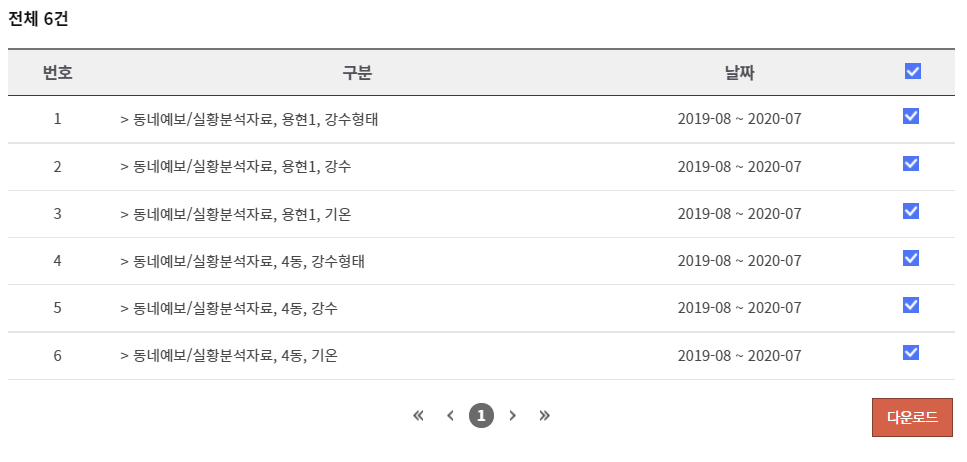

원래의 계획은 이렇게 다운받은 데이터를 구글 클라우드에 올리고, 코랩에서 압축두번 풀고 바로 작업하는 것이었다. 그러나 기상자료개방포털에서 위와같이 파일이름이 ,로 구분됨에 따라(다운로드 하면 _로 바뀐다) 숭의 1,3동/도화2,3동/용현1,4동 과 같이 ,로 구분된 지역이 파일이 나뉘어 게재되고, 다운로드 되었다. 실제 데이터는 4동과 같이 뒷부분 이름에만 들어있다. 코랩에서는 이것을 파악하기 어려워서 윈도우에서 압축을 풀고 파일명을 바꾸거나 몇개의 파일을 삭제한 뒤 csv파일만 남긴 후 압축하여 구글 드라이브로 다시 업로드 하였다.

In [4]:
#우분투에서 다운받아 파일이름의 한글이 깨지므로 압축을 해제할 때 인코딩을 지정해주자.
!unzip -O cp949 '/content/drive/MyDrive/weathers/weathers.zip' -d '/content/'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/weathers/증포동_강수형태_202108_202108.csv  
  inflating: /content/weathers/증포동_기온_201908_202007.csv  
  inflating: /content/weathers/증포동_기온_202008_202107.csv  
  inflating: /content/weathers/증포동_기온_202108_202108.csv  
  inflating: /content/weathers/지곡면_강수_201908_202007 (2).csv  
  inflating: /content/weathers/지곡면_강수_201908_202007.csv  
  inflating: /content/weathers/지곡면_강수_202008_202107 (2).csv  
  inflating: /content/weathers/지곡면_강수_202008_202107.csv  
  inflating: /content/weathers/지곡면_강수_202108_202108 (2).csv  
  inflating: /content/weathers/지곡면_강수_202108_202108.csv  
  inflating: /content/weathers/지곡면_강수형태_201908_202007 (2).csv  
  inflating: /content/weathers/지곡면_강수형태_201908_202007.csv  
  inflating: /content/weathers/지곡면_강수형태_202008_202107 (2).csv  
  inflating: /content/weathers/지곡면_강수형태_202008_202107.csv  
  inflating: /content/weathers/지곡면_강수형태_202108_202108 (2).csv  
  inflating: /content/weathers/지곡면_강수형태_202108_202108.csv 

In [60]:
file_list = glob.glob('/content/weathers/*.csv')
print(file_list[0])
len(file_list)

/content/weathers/가천면_강수_201908_202007.csv


31596

In [61]:
rain_list=[]
temp_list=[]
rainSnow_list=[]


for fname in file_list:
  # print(fname)
  if len(fname.split("_"))>4: #대정읍_마라도포함_강수_201908_202007 (9개존재)
    if fname.split("_")[2].endswith('강수형태'):
      rainSnow_list.append(fname)
    if fname.split("_")[2].endswith('기온'):
      temp_list.append(fname)
    if fname.split("_")[2].endswith('강수'):
      rain_list.append(fname)
  else:
    if fname.split("_")[1].endswith('강수형태'):
      rainSnow_list.append(fname)
    if fname.split("_")[1].endswith('기온'):
      temp_list.append(fname)
    if fname.split("_")[1].endswith('강수'):
      rain_list.append(fname)
  


총 31590개의 데이터가 필요한데 내가 다운받으면서 6개가 중복으로 들어간것 같다. </br>
31590/3 = 10530 개씩 강수, 강수형태, 기온 데이터가 존재해야하는데 부족하지 않으므로 나중에 duplicate로 살펴보는 것으로 하자.

In [33]:
print("rain_list",len(rain_list))
print("temp_list",len(temp_list))
print("rainSnow_list",len(rainSnow_list))
temp_list[-20:]

rain_list 10532
temp_list 10533
rainSnow_list 10531


['/content/weathers/신당동_기온_201908_202007.csv',
 '/content/weathers/금강송면_기온_201908_202007.csv',
 '/content/weathers/대청동_기온_202008_202107.csv',
 '/content/weathers/동백3동_기온_201908_202007.csv',
 '/content/weathers/능곡동_기온_202108_202108.csv',
 '/content/weathers/화서1동_기온_201908_202007.csv',
 '/content/weathers/연지동_기온_201908_202007.csv',
 '/content/weathers/성덕동_기온_202008_202107.csv',
 '/content/weathers/고한읍_기온_202008_202107.csv',
 '/content/weathers/복산1동_기온_202008_202107.csv',
 '/content/weathers/시기동_기온_202108_202108.csv',
 '/content/weathers/동송읍_기온_201908_202007.csv',
 '/content/weathers/청라1동_기온_201908_202007.csv',
 '/content/weathers/개포면_기온_201908_202007.csv',
 '/content/weathers/황성동_기온_202008_202107.csv',
 '/content/weathers/불당동_기온_202008_202107.csv',
 '/content/weathers/등촌제2동_기온_201908_202007.csv',
 '/content/weathers/온정면_기온_201908_202007.csv',
 '/content/weathers/괘법동_기온_201908_202007.csv',
 '/content/weathers/도곡2동_기온_202108_202108.csv']

In [47]:
for item in rain_list:
  if item.split("_")[0].endswith('용현1,4동'):
    print(item)

/content/weathers/용현1,4동_강수_202108_202108.csv
/content/weathers/용현1,4동_강수_202008_202107.csv
/content/weathers/용현1,4동_강수_201908_202007.csv


## 1.2 데이터 파악하기

* 첫번째 열 이름은 ' format: day'이고 마지막 열 이름은 'value location:81_91 Start : 20190801 '이다. **공백 주의**.
* value_location의 값은 **격자 X_격자 Y**값이다.
* 첫 시작일은 'value location:81_91 Start : 20190801 '에서 얻을 수 있고, day가 마지막 날이 되면 ' format: day'에 'Start : 20190901' 형태로 다음달 첫날 등장한다.

In [43]:
sample = pd.read_csv('/content/weathers/가천면_강수_201908_202007.csv')
sample

,format: day,hour,value location:81_91 Start : 20190801
0,1,0.0,0.0
1,1,100.0,0.0
2,1,200.0,0.0
3,1,300.0,0.0
4,1,400.0,0.0
...,...,...,...
8790,31,1900.0,0.0
8791,31,2000.0,0.0
8792,31,2100.0,0.0
8793,31,2200.0,0.0


In [37]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 3 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0    format: day                            8795 non-null   object 
 1   hour                                    8784 non-null   float64
 2   value location:81_91 Start : 20190801   8784 non-null   float64
dtypes: float64(2), object(1)
memory usage: 206.3+ KB


In [38]:
sample.columns

Index([' format: day', 'hour', 'value location:81_91 Start : 20190801 '], dtype='object')

In [42]:
sample[740:750]

,format: day,hour,value location:81_91 Start : 20190801
740,31,2000.0,0.0
741,31,2100.0,0.0
742,31,2200.0,0.0
743,31,2300.0,0.0
744,Start : 20190901,NaN,NaN
745,1,0.0,0.0
746,1,100.0,0.0
747,1,200.0,0.0
748,1,300.0,0.0
749,1,400.0,0.0


3가지 리스트를 먼저 길이를 재고, 개수가 똑같으면 zip으로 묶자. 만약에 어떤거 하나가....숫자가 다르다면....골치아프군.... <=지금 여깈ㅋㅋㅋ
http://www.gisdeveloper.co.kr/?p=8255
**outer join으로 합치기!**

# 2. 데이터프레임으로 만들기

In [40]:
location = pd.read_excel('/content/drive/MyDrive/기상청41_단기예보 조회서비스_오픈API활용가이드_격자_위경도(20210401).xlsx', engine='openpyxl')
location

,구분,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100),위치업데이트,Unnamed: 16
0,kor,1100000000,서울특별시,NaN,NaN,60,127,126,58,48.03,37,33,48.85,126.980008,37.563569,NaN,NaN
1,kor,1111000000,서울특별시,종로구,NaN,60,127,126,58,53.91,37,34,13.36,126.981642,37.570378,NaN,NaN
2,kor,1111051500,서울특별시,종로구,청운효자동,60,127,126,58,14.35,37,35,2.89,126.970652,37.584137,NaN,NaN
3,kor,1111053000,서울특별시,종로구,사직동,60,127,126,58,15.44,37,34,23.77,126.970956,37.573269,NaN,NaN
4,kor,1111054000,서울특별시,종로구,삼청동,60,127,126,59,2.32,37,34,56.73,126.983978,37.582425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,kor,5013060000,제주특별자치도,서귀포시,대천동,52,32,126,28,46.47,33,14,50.91,126.479575,33.247475,NaN,NaN
3770,kor,5013061000,제주특별자치도,서귀포시,중문동,51,32,126,26,12.40,33,14,53.44,126.436778,33.248178,NaN,NaN
3771,kor,5013062000,제주특별자치도,서귀포시,예래동,50,32,126,23,59.67,33,15,3.69,126.399908,33.251025,NaN,NaN
3772,kor,5019000000,이어도,NaN,NaN,28,8,0,0,0.00,0,0,0.00,0.000000,0.000000,NaN,NaN


In [100]:
rain_df = pd.DataFrame(columns=['날짜', '시간대', '읍면동', '강수형태','격자 X','격자 Y'])

In [101]:
rain_df

,날짜,시간대,읍면동,강수,격자 X,격자 Y


데이터프레임을 일일히 읽어서 합치는것은 매우 오래 걸리므로 다른 곳으로 이동하고 싶다면 중간에 코랩의 런타임을 유지시키기 위해 F12를 눌러 콘솔에
아래의 코드를 붙여넣고 엔터를 누르자. 30분에 한번씩 코랩의 툴바가 클릭될 것이다.

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect, 1800000)
```




In [ ]:
for fname in rain_list:
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2]
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼 추가 후 값 넣기'''
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  df.columns = ['날짜','시간대','강수']
  df.loc[:,'읍면동'] = level3 
  df.loc[:,'격자 X'] = xy[0]
  df.loc[:,'격자 Y'] = xy[1]
  
  '''날짜 col 재정의'''
  df = df.astype({'날짜': 'string'})
  for i in range(len(df)):
    if df.loc[i,'날짜'].startswith(' Start'):
      start_date = df.loc[i,'날짜'][-9:-3] #
      continue
    df.loc[i,'날짜'] = start_date + df.loc[i,'날짜'] #이부분이 시간이 가장 오래걸림!
  
  '''재정렬 및 합치기'''
  df = df[['날짜', '시간대', '읍면동', '강수','격자 X','격자 Y']]
  rain_df = pd.concat([rain_df, df], ignore_index=True)

'''날짜 col 정제'''
rain_df = rain_df.drop(rain_df[rain_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
rain_df['날짜'] = pd.to_datetime(rain_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대바꾸기'''
rain_df= rain_df.astype({'시간대': 'int'}) 
rain_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in rain_df['시간대']]

rain_df  

In [ ]:
rain_df.to_csv('/content/drive/MyDrive/강수_2019_2021.csv',index=False, encoding="utf-8-sig")
rain_df.to_excel('/content/drive/MyDrive/강수_2019_2021.xlsx',index=False, encoding="utf-8-sig")

> 메모리 덜 쓰고 Pandas DataFrame 병합을 빠르게 하는 방법(여러 개의 용량 큰 파일) : https://emilkwak.github.io/pandas-dataframe-concat-efficiently

나는 그런데 그대로 병합하면 안되고, 각 프레임별로 읍면동, 격자X, 격자 Y데이터를 함께 붙여야 한다.

## 방법 2. 모든 데이터를 리스트에 각각 담아서 열로 붙이기

In [ ]:
temp_df = pd.DataFrame(columns=['날짜', '시간대','읍면동', '기온','격자X','격자Y'])

In [ ]:
date=[]
level3_list=[]
x=[]
y=[]
hour=[]
temp=[]

for j,fname in enumerate(temp_list):
  print(j)
  df = pd.read_csv(fname)

  '''필요한 날짜, 격자X, 격자 Y, 읍면동 정보 얻기'''
  start_date = df.columns[-1].strip()[-8:-2]
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼명 재정의'''
  df.columns = ['날짜','시간대','기온']
  
  '''Start검색을 위해 날짜 컬럼 string 타입으로 변경'''
  df = df.astype({'날짜': 'string'})
  for i in range(len(df)):
    if df.loc[i,'날짜'].startswith(' Start'):
      start_date = df.loc[i,'날짜'][-9:-3] #
      continue
    date.append(start_date + df.loc[i,'날짜'])
    level3_list.append(level3)
    x.append(xy[0])
    y.append(xy[1])
    hour.append(df.loc[i,'시간대'])
    temp.append(df.loc[i,'기온'])

In [ ]:
'''데이터 프레임의 열로 합치기'''
temp_df['날짜'] = date
temp_df['시간대'] = hour
temp_df['읍면동'] = level3_list
temp_df['기온'] = temp
temp_df['격자X'] = x
temp_df['격자Y'] = y

'''날짜 col 정제'''
# temp_df = temp_df.drop(temp_df[temp_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
temp_df['날짜'] = pd.to_datetime(temp_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대 배달데이터 형태로 바꾸기'''
temp_df= temp_df.astype({'시간대': 'int'}) 
temp_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in temp_df['시간대']]

temp_df 

In [ ]:
temp_df.to_csv('/content/drive/MyDrive/온도_2019_2021.csv',index=False, encoding="utf-8-sig")
temp_df.to_excel('/content/drive/MyDrive/온도_2019_2021.xlsx',index=False, encoding="utf-8-sig")

## 방법3. 데이터프레임을 리스트에 담아서 concat 제대로 활용하기


방법1의 경우 루프를 돌때마다 concat을 사용하는 방법으로 이렇게 concat함수를 동적으로 사용하는 것은 concat의 이점을 리지 못해 append보다 더 오래 걸릴 수 있다. 따라서 결합할 데이터프레임을 먼저 리스트로 모아주고, concat함수에서 이를 인자로 받아 활용하면 더욱 빠르게 데이터프레임을 결합할 수 있다.

In [ ]:
rainSnow_df = pd.DataFrame(columns=['날짜', '시간대','읍면동','강수형태','격자X','격자Y'])
rainSnow_df

In [ ]:
concat_list=[]
for fname in rainSnow_list:
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2]
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼 추가 후 값 넣기'''
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  df.columns = ['날짜','시간대','기온']
  df.loc[:,'읍면동'] = level3 
  df.loc[:,'격자 X'] = xy[0]
  df.loc[:,'격자 Y'] = xy[1]
  
  '''날짜 col 재정의'''
  df = df.astype({'날짜': 'string'})
  for i in range(len(df)):
    if df.loc[i,'날짜'].startswith(' Start'):
      start_date = df.loc[i,'날짜'][-9:-3] #
      continue
    df.loc[i,'날짜'] = start_date + df.loc[i,'날짜']
  
  '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
  df = df[['날짜', '시간대', '읍면동', '강수형태','격자 X','격자 Y']]
  concat_list.append(df)


In [ ]:
rainSnow_df = pd.concat(concat_list, ignore_index=True)

'''날짜 col 정제'''
rainSnow_df = rainSnow_df.drop(rainSnow_df[rainSnow_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
rainSnow_df['날짜'] = pd.to_datetime(rainSnow_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대 배달데이터 형태로 바꾸기'''
rainSnow_df= rainSnow_df.astype({'시간대': 'int'}) 
rainSnow_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in rainSnow_df['시간대']]

rainSnow_df

In [ ]:
rainSnow_df.to_csv('/content/drive/MyDrive/강수형태_2019_2021.csv',index=False, encoding="utf-8-sig")
rainSnow_df.to_excel('/content/drive/MyDrive/강수형태_2019_2021.xlsx',index=False, encoding="utf-8-sig")